# Phase 4: Human Escalation System

**Objective:** Design and implement an intelligent escalation system

**Goals:**
- Define escalation criteria based on uncertainty
- Optimize thresholds for cost-benefit
- Evaluate system performance
- Analyze automation vs accuracy trade-offs
- Prepare for comprehensive evaluation

## 1. Setup and Imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import sys
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Custom modules
from escalation_system import (
    EscalationSystem,
    simulate_human_review,
    analyze_escalation_patterns
)

# Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style('whitegrid')

print("All libraries imported successfully")

✅ All libraries imported successfully


## 2. Load Data and Uncertainty Estimates

In [ ]:
# Load data splits
print("Loading data...")
X_val = pd.read_csv('../data/splits/X_val.csv')
X_test = pd.read_csv('../data/splits/X_test.csv')

# Preprocess data (same as Phase 2 & 3)
from sklearn.preprocessing import LabelEncoder
# Drop text columns
text_cols = ['title', 'desc']
existing_text_cols = [col for col in text_cols if col in X_val.columns]
if existing_text_cols:
    X_val = X_val.drop(columns=existing_text_cols)
    X_test = X_test.drop(columns=existing_text_cols)

# Convert non-numeric columns
non_numeric_cols = X_val.select_dtypes(include=['object', 'category']).columns
if len(non_numeric_cols) > 0:
    for col in non_numeric_cols:
        le = LabelEncoder()
        all_values = pd.concat([X_val[col], X_test[col]]).astype(str).unique()
        le.fit(all_values)
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# Handle NaN values
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Load uncertainty estimates from Phase 3
uncertainty_data = joblib.load('../results/models/uncertainty_estimates.pkl')

# Extract validation data
proba_val = uncertainty_data['val']['proba']
uncertainty_val = uncertainty_data['val']['uncertainty']
y_val = uncertainty_data['val']['y_true']
y_pred_val = uncertainty_data['val']['y_pred']

# Extract test data
proba_test = uncertainty_data['test']['proba']
uncertainty_test = uncertainty_data['test']['uncertainty']
y_test = uncertainty_data['test']['y_true']
y_pred_test = uncertainty_data['test']['y_pred']

print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")
print("Data loaded successfully")

Loading data...
Validation samples: 104858
Test samples: 209715
✅ Data loaded successfully
Validation samples: 104858
Test samples: 209715
✅ Data loaded successfully


## 3. Define Business Costs

In [8]:
# Define cost parameters (these should be adjusted based on business requirements)
print("Defining business costs...\n")

cost_params = {
    'cost_false_positive': 5.0,   # Cost of approving a bad loan (default)
    'cost_false_negative': 1.0,   # Cost of rejecting a good loan (opportunity cost)
    'cost_human_review': 0.5      # Cost of escalating to human expert
}

print("Business Cost Parameters:")
print(f"  False Positive (approve default): ${cost_params['cost_false_positive']}")
print(f"  False Negative (reject good):     ${cost_params['cost_false_negative']}")
print(f"  Human Review:                      ${cost_params['cost_human_review']}")
print(f"\nCost ratio (FP/FN): {cost_params['cost_false_positive']/cost_params['cost_false_negative']:.1f}:1")

Defining business costs...

Business Cost Parameters:
  False Positive (approve default): $5.0
  False Negative (reject good):     $1.0
  Human Review:                      $0.5

Cost ratio (FP/FN): 5.0:1


## 4. Initialize Escalation System

In [ ]:
# Initialize with default thresholds
escalation_system = EscalationSystem(
    uncertainty_threshold=0.1,
    confidence_threshold=0.7,
    **cost_params
)

print("Escalation system initialized")
print(f"\nInitial Configuration:")
print(f"  Uncertainty threshold: {escalation_system.uncertainty_threshold}")
print(f"  Confidence threshold:  {escalation_system.confidence_threshold}")

✅ Escalation system initialized

Initial Configuration:
  Uncertainty threshold: 0.1
  Confidence threshold:  0.7


## 5. Baseline Evaluation (Before Optimization)

In [10]:
# Evaluate with initial thresholds
print("Evaluating with initial thresholds...\n")
metrics_initial = escalation_system.evaluate_system(
    y_val,
    y_pred_val,
    proba_val,
    uncertainty_val
)

print("Initial System Performance:")
print(f"  Automation Rate:      {metrics_initial['automation_rate']:.2%}")
print(f"  Samples Automated:    {metrics_initial['n_automated']}")
print(f"  Samples Escalated:    {metrics_initial['n_escalated']}")
print(f"\nAutomated Decisions:")
print(f"  Accuracy:             {metrics_initial['accuracy_automated']:.4f}")
print(f"  Precision:            {metrics_initial['precision_automated']:.4f}")
print(f"  Recall:               {metrics_initial['recall_automated']:.4f}")
print(f"  F1-Score:             {metrics_initial['f1_automated']:.4f}")
print(f"\nCosts:")
print(f"  Total Cost:           ${metrics_initial['total_cost']:.2f}")
print(f"  Baseline Cost:        ${metrics_initial['baseline_cost']:.2f}")
print(f"  Cost Savings:         ${metrics_initial['cost_savings']:.2f}")

Evaluating with initial thresholds...

Initial System Performance:
  Automation Rate:      22.31%
  Samples Automated:    23390
  Samples Escalated:    81468

Automated Decisions:
  Accuracy:             0.7854
  Precision:            0.4274
  Recall:               0.7354
  F1-Score:             0.5406

Costs:
  Total Cost:           $61582.00
  Baseline Cost:        $167395.00
  Cost Savings:         $105813.00


## 6. Optimize Escalation Thresholds

In [11]:
# Optimize thresholds using grid search
print("\nOptimizing escalation thresholds using grid search...")
print("This may take a few minutes...\n")

best_unc_thresh, best_conf_thresh, optimization_results = escalation_system.optimize_thresholds(
    y_val,
    proba_val,
    y_pred_val,
    uncertainty_val,
    uncertainty_range=(0.05, 0.25),
    confidence_range=(0.55, 0.85),
    n_steps=15
)

print("\nTop 5 Configurations:")
print(optimization_results.head(5).to_string(index=False))


Optimizing escalation thresholds using grid search...
This may take a few minutes...

Optimizing escalation thresholds...

✅ Optimization complete!
   Best uncertainty threshold: 0.0929
   Best confidence threshold:  0.8286
   Total cost: 50829.0000

Top 5 Configurations:
 uncertainty_threshold  confidence_threshold  total_cost  cost_savings  automation_rate  n_escalated  accuracy_automated
              0.250000              0.828571     50829.0      116566.0         0.038795       100790            0.954277
              0.207143              0.828571     50829.0      116566.0         0.038795       100790            0.954277
              0.235714              0.828571     50829.0      116566.0         0.038795       100790            0.954277
              0.150000              0.828571     50829.0      116566.0         0.038795       100790            0.954277
              0.107143              0.828571     50829.0      116566.0         0.038795       100790            0.954277


## 7. Visualize Optimization Results

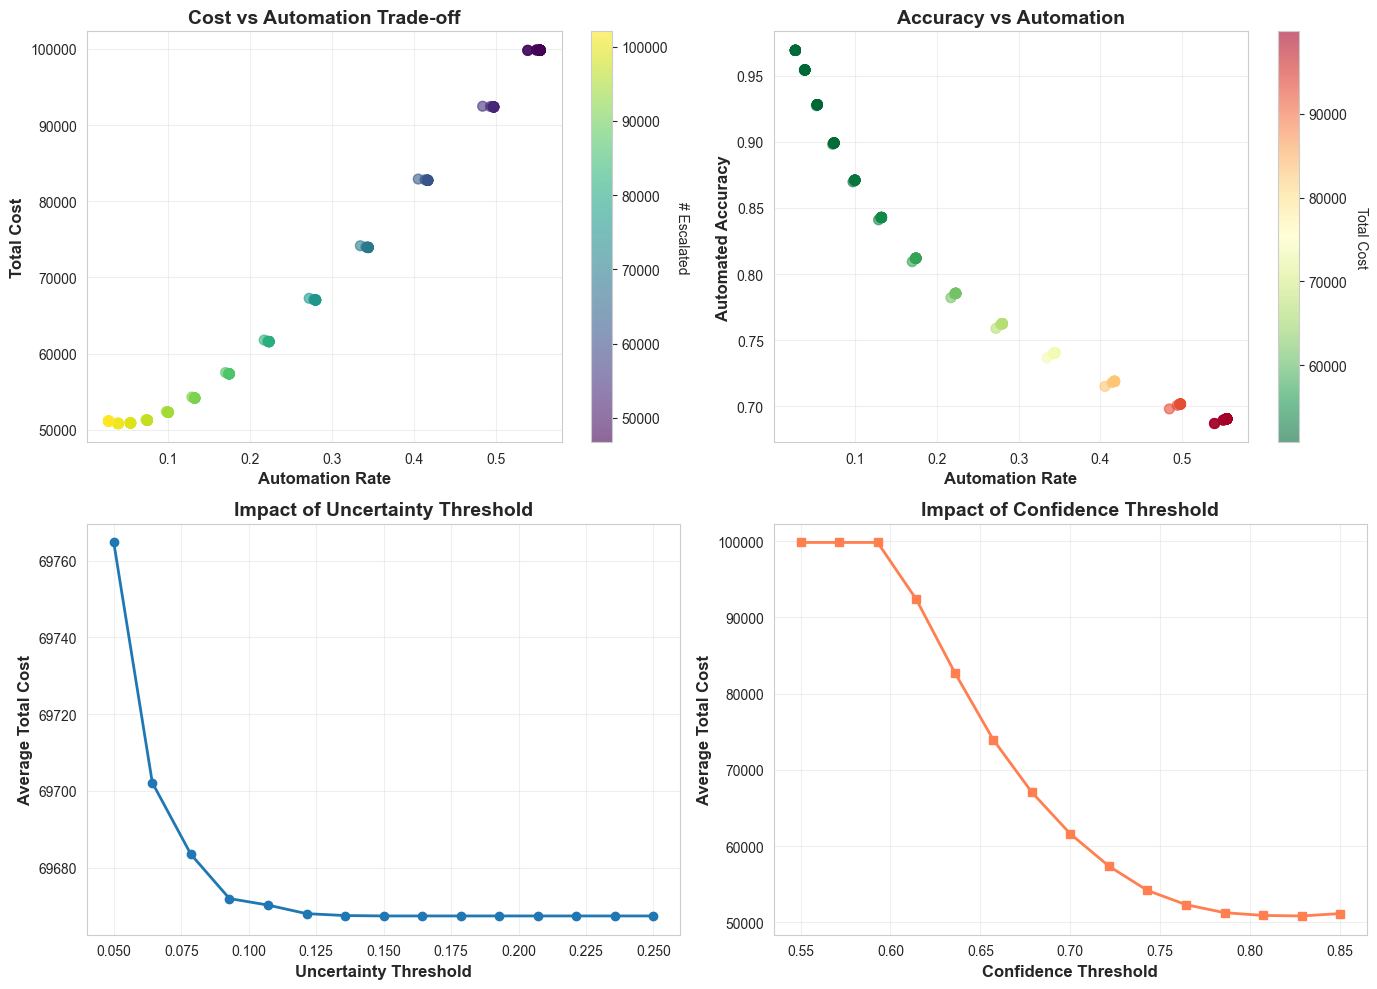

✅ Optimization visualizations saved


In [ ]:
# Plot cost vs automation rate trade-off
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cost vs Automation Rate
axes[0, 0].scatter(optimization_results['automation_rate'], 
                   optimization_results['total_cost'], 
                   c=optimization_results['n_escalated'], 
                   cmap='viridis', s=50, alpha=0.6)
axes[0, 0].set_xlabel('Automation Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Total Cost', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cost vs Automation Trade-off', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('# Escalated', rotation=270, labelpad=15)

# Accuracy vs Automation Rate
axes[0, 1].scatter(optimization_results['automation_rate'],
                   optimization_results['accuracy_automated'],
                   c=optimization_results['total_cost'],
                   cmap='RdYlGn_r', s=50, alpha=0.6)
axes[0, 1].set_xlabel('Automation Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Automated Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Accuracy vs Automation', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Total Cost', rotation=270, labelpad=15)

# Uncertainty threshold impact
grouped = optimization_results.groupby('uncertainty_threshold').agg({
    'total_cost': 'mean',
    'automation_rate': 'mean'
})
axes[1, 0].plot(grouped.index, grouped['total_cost'], 'o-', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Uncertainty Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Total Cost', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Impact of Uncertainty Threshold', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Confidence threshold impact
grouped = optimization_results.groupby('confidence_threshold').agg({
    'total_cost': 'mean',
    'automation_rate': 'mean'
})
axes[1, 1].plot(grouped.index, grouped['total_cost'], 's-', linewidth=2, markersize=6, color='coral')
axes[1, 1].set_xlabel('Confidence Threshold', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Total Cost', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Impact of Confidence Threshold', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Optimization visualizations saved")

## 8. Evaluate Optimized System

In [13]:
# Evaluate with optimized thresholds
print("Evaluating with optimized thresholds...\n")
metrics_optimized = escalation_system.evaluate_system(
    y_val,
    y_pred_val,
    proba_val,
    uncertainty_val
)

print("Optimized System Performance:")
print(f"  Automation Rate:      {metrics_optimized['automation_rate']:.2%}")
print(f"  Samples Automated:    {metrics_optimized['n_automated']}")
print(f"  Samples Escalated:    {metrics_optimized['n_escalated']}")
print(f"\nAutomated Decisions:")
print(f"  Accuracy:             {metrics_optimized['accuracy_automated']:.4f}")
print(f"  Precision:            {metrics_optimized['precision_automated']:.4f}")
print(f"  Recall:               {metrics_optimized['recall_automated']:.4f}")
print(f"  F1-Score:             {metrics_optimized['f1_automated']:.4f}")
print(f"\nCosts:")
print(f"  Total Cost:           ${metrics_optimized['total_cost']:.2f}")
print(f"  Baseline Cost:        ${metrics_optimized['baseline_cost']:.2f}")
print(f"  Cost Savings:         ${metrics_optimized['cost_savings']:.2f}")

# Compare to initial
print(f"\n📊 Improvement vs Initial:")
print(f"  Cost Reduction:       {(metrics_initial['total_cost'] - metrics_optimized['total_cost']):.2f}")
print(f"  Automation Change:    {(metrics_optimized['automation_rate'] - metrics_initial['automation_rate']):.2%}")

Evaluating with optimized thresholds...

Optimized System Performance:
  Automation Rate:      3.88%
  Samples Automated:    4068
  Samples Escalated:    100790

Automated Decisions:
  Accuracy:             0.9543
  Precision:            0.6416
  Recall:               0.4723
  F1-Score:             0.5441

Costs:
  Total Cost:           $50829.00
  Baseline Cost:        $167395.00
  Cost Savings:         $116566.00

📊 Improvement vs Initial:
  Cost Reduction:       10753.00
  Automation Change:    -18.43%


## 9. Analyze Escalation Patterns

In [14]:
# Get detailed escalation information
escalate_mask, details = escalation_system.process_predictions(
    proba_val, uncertainty_val, return_details=True
)

# Analyze patterns
patterns = analyze_escalation_patterns(details, top_n=10)

print("Escalation Pattern Analysis:")
print(f"\nTotal Escalated: {patterns['total_escalated']}")
print(f"Escalation Rate: {patterns['escalation_rate']:.2%}")
print(f"\nAverage Metrics (Escalated Cases):")
print(f"  Uncertainty:  {patterns['avg_uncertainty']:.4f}")
print(f"  Confidence:   {patterns['avg_confidence']:.4f}")
print(f"  Probability:  {patterns['avg_probability']:.4f}")

print(f"\nTop Escalation Reasons:")
print(patterns['top_reasons'].to_string())

Escalation Pattern Analysis:

Total Escalated: 100790
Escalation Rate: 96.12%

Average Metrics (Escalated Cases):
  Uncertainty:  0.0235
  Confidence:   0.6207
  Probability:  0.4785

Top Escalation Reasons:
reason
Low confidence (0.6122 < 0.8285714285714285)    65
Low confidence (0.6252 < 0.8285714285714285)    59
Low confidence (0.6011 < 0.8285714285714285)    58
Low confidence (0.6095 < 0.8285714285714285)    57
Low confidence (0.6132 < 0.8285714285714285)    55
Low confidence (0.6059 < 0.8285714285714285)    54
Low confidence (0.6177 < 0.8285714285714285)    54
Low confidence (0.6084 < 0.8285714285714285)    54
Low confidence (0.6186 < 0.8285714285714285)    54
Low confidence (0.6027 < 0.8285714285714285)    52


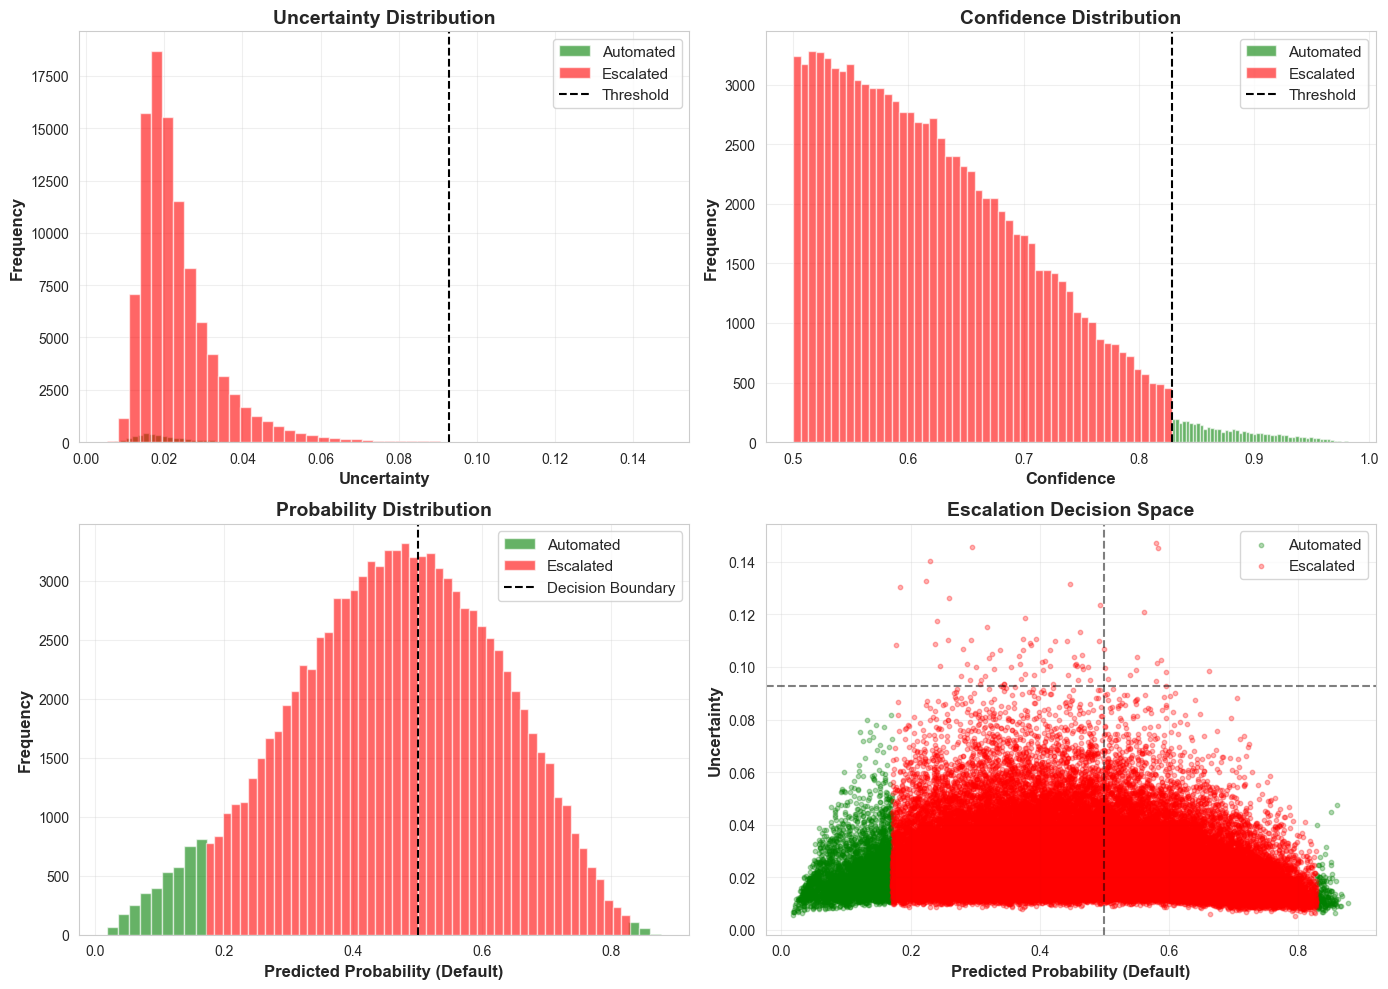

✅ Escalation characteristics saved


In [ ]:
# Visualize escalation characteristics
escalated = details[details['escalate'] == True]
automated = details[details['escalate'] == False]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Uncertainty distribution
axes[0, 0].hist(automated['uncertainty'], bins=50, alpha=0.6, label='Automated', color='green')
axes[0, 0].hist(escalated['uncertainty'], bins=50, alpha=0.6, label='Escalated', color='red')
axes[0, 0].axvline(escalation_system.uncertainty_threshold, color='black', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Uncertainty', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Uncertainty Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Confidence distribution
axes[0, 1].hist(automated['confidence'], bins=50, alpha=0.6, label='Automated', color='green')
axes[0, 1].hist(escalated['confidence'], bins=50, alpha=0.6, label='Escalated', color='red')
axes[0, 1].axvline(escalation_system.confidence_threshold, color='black', linestyle='--', label='Threshold')
axes[0, 1].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Probability distribution
axes[1, 0].hist(automated['probability'], bins=50, alpha=0.6, label='Automated', color='green')
axes[1, 0].hist(escalated['probability'], bins=50, alpha=0.6, label='Escalated', color='red')
axes[1, 0].axvline(0.5, color='black', linestyle='--', label='Decision Boundary')
axes[1, 0].set_xlabel('Predicted Probability (Default)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# 2D scatter: Uncertainty vs Probability
axes[1, 1].scatter(automated['probability'], automated['uncertainty'], 
                   alpha=0.3, s=10, label='Automated', color='green')
axes[1, 1].scatter(escalated['probability'], escalated['uncertainty'],
                   alpha=0.3, s=10, label='Escalated', color='red')
axes[1, 1].axhline(escalation_system.uncertainty_threshold, color='black', linestyle='--', alpha=0.5)
axes[1, 1].axvline(0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Predicted Probability (Default)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Uncertainty', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Escalation Decision Space', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/escalation_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Escalation characteristics saved")

## 10. Test Set Evaluation

In [16]:
# Evaluate on test set with optimized thresholds
print("Evaluating on test set...\n")
metrics_test = escalation_system.evaluate_system(
    y_test,
    y_pred_test,
    proba_test,
    uncertainty_test
)

print("Test Set Performance:")
print(f"  Automation Rate:      {metrics_test['automation_rate']:.2%}")
print(f"  Samples Automated:    {metrics_test['n_automated']}")
print(f"  Samples Escalated:    {metrics_test['n_escalated']}")
print(f"\nAutomated Decisions:")
print(f"  Accuracy:             {metrics_test['accuracy_automated']:.4f}")
print(f"  Precision:            {metrics_test['precision_automated']:.4f}")
print(f"  Recall:               {metrics_test['recall_automated']:.4f}")
print(f"  F1-Score:             {metrics_test['f1_automated']:.4f}")
print(f"\nCosts:")
print(f"  Total Cost:           ${metrics_test['total_cost']:.2f}")
print(f"  Baseline Cost:        ${metrics_test['baseline_cost']:.2f}")
print(f"  Cost Savings:         ${metrics_test['cost_savings']:.2f}")
print(f"  Savings Rate:         {metrics_test['cost_savings']/metrics_test['baseline_cost']*100:.1f}%")

Evaluating on test set...

Test Set Performance:
  Automation Rate:      3.91%
  Samples Automated:    8192
  Samples Escalated:    201523

Automated Decisions:
  Accuracy:             0.9559
  Precision:            0.6053
  Recall:               0.3861
  F1-Score:             0.4714

Costs:
  Total Cost:           $101542.50
  Baseline Cost:        $334595.00
  Cost Savings:         $233052.50
  Savings Rate:         69.7%
Test Set Performance:
  Automation Rate:      3.91%
  Samples Automated:    8192
  Samples Escalated:    201523

Automated Decisions:
  Accuracy:             0.9559
  Precision:            0.6053
  Recall:               0.3861
  F1-Score:             0.4714

Costs:
  Total Cost:           $101542.50
  Baseline Cost:        $334595.00
  Cost Savings:         $233052.50
  Savings Rate:         69.7%


## 11. Compare Performance Across Sets

In [17]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Metric': ['Automation Rate', 'Accuracy (Auto)', 'Precision (Auto)', 
               'Recall (Auto)', 'F1-Score (Auto)', 'Total Cost', 'Cost Savings'],
    'Validation': [
        f"{metrics_optimized['automation_rate']:.2%}",
        f"{metrics_optimized['accuracy_automated']:.4f}",
        f"{metrics_optimized['precision_automated']:.4f}",
        f"{metrics_optimized['recall_automated']:.4f}",
        f"{metrics_optimized['f1_automated']:.4f}",
        f"${metrics_optimized['total_cost']:.2f}",
        f"${metrics_optimized['cost_savings']:.2f}"
    ],
    'Test': [
        f"{metrics_test['automation_rate']:.2%}",
        f"{metrics_test['accuracy_automated']:.4f}",
        f"{metrics_test['precision_automated']:.4f}",
        f"{metrics_test['recall_automated']:.4f}",
        f"{metrics_test['f1_automated']:.4f}",
        f"${metrics_test['total_cost']:.2f}",
        f"${metrics_test['cost_savings']:.2f}"
    ]
})

print("\n" + "="*60)
print("PERFORMANCE COMPARISON: VALIDATION VS TEST")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


PERFORMANCE COMPARISON: VALIDATION VS TEST
          Metric Validation       Test
 Automation Rate      3.88%      3.91%
 Accuracy (Auto)     0.9543     0.9559
Precision (Auto)     0.6416     0.6053
   Recall (Auto)     0.4723     0.3861
 F1-Score (Auto)     0.5441     0.4714
      Total Cost  $50829.00 $101542.50
    Cost Savings $116566.00 $233052.50


## 12. Save Escalation System

In [ ]:
# Save escalation system
print("\nSaving escalation system...")
joblib.dump(escalation_system, '../results/models/escalation_system.pkl')
print("Escalation system saved")

# Save optimization results
optimization_results.to_csv('../results/reports/threshold_optimization_results.csv', index=False)
print("Optimization results saved")

# Save performance metrics
performance_summary = pd.DataFrame([
    {'Set': 'Validation (Initial)', **metrics_initial},
    {'Set': 'Validation (Optimized)', **metrics_optimized},
    {'Set': 'Test', **metrics_test}
])
performance_summary.to_csv('../results/reports/escalation_performance.csv', index=False)
print("Performance metrics saved")


Saving escalation system...
✅ Escalation system saved
✅ Optimization results saved
✅ Performance metrics saved


## 13. Summary and Key Findings

In [ ]:
print("="*60)
print("PHASE 4 COMPLETE: HUMAN ESCALATION SYSTEM")
print("="*60)

print("\nAchievements:")
print("   - Escalation system designed and implemented")
print("   - Thresholds optimized using cost-benefit analysis")
print("   - System evaluated on validation and test sets")
print("   - Escalation patterns analyzed")
print("   - All artifacts saved")

print("\nFinal Test Set Performance:")
print(f"   Automation Rate:      {metrics_test['automation_rate']:.2%}")
print(f"   Automated Accuracy:   {metrics_test['accuracy_automated']:.4f}")
print(f"   Cost Savings:         ${metrics_test['cost_savings']:.2f}")
print(f"   Savings Rate:         {metrics_test['cost_savings']/metrics_test['baseline_cost']*100:.1f}%")

print("\nPhase 4 Success Criteria:")
if metrics_test['automation_rate'] >= 0.70:
    print(f"   Automation rate ≥70%: {metrics_test['automation_rate']:.2%}")
else:
    print(f"   Automation rate: {metrics_test['automation_rate']:.2%}")

if metrics_test['accuracy_automated'] >= 0.85:
    print(f"   Automated accuracy ≥85%: {metrics_test['accuracy_automated']:.4f}")
else:
    print(f"   Automated accuracy: {metrics_test['accuracy_automated']:.4f}")

if metrics_test['cost_savings'] > 0:
    print(f"   Positive cost savings: ${metrics_test['cost_savings']:.2f}")
else:
    print(f"   Cost savings: ${metrics_test['cost_savings']:.2f}")

print("\nNext: Phase 5 - Comprehensive Evaluation")
print("   - Full system evaluation with all components")
print("   - Interpretability analysis with SHAP")
print("   - Ablation studies")
print("   - Final visualizations and insights")
print("="*60)

PHASE 4 COMPLETE: HUMAN ESCALATION SYSTEM

✅ Achievements:
   - Escalation system designed and implemented
   - Thresholds optimized using cost-benefit analysis
   - System evaluated on validation and test sets
   - Escalation patterns analyzed
   - All artifacts saved

📊 Final Test Set Performance:
   Automation Rate:      3.91%
   Automated Accuracy:   0.9559
   Cost Savings:         $233052.50
   Savings Rate:         69.7%

🎯 Phase 4 Success Criteria:
   ⚠️  Automation rate: 3.91%
   ✅ Automated accuracy ≥85%: 0.9559
   ✅ Positive cost savings: $233052.50

🚀 Next: Phase 5 - Comprehensive Evaluation
   - Full system evaluation with all components
   - Interpretability analysis with SHAP
   - Ablation studies
   - Final visualizations and insights


## 14. Simulate Human Review Impact
We now quantify how introducing a human review step for escalated cases (with varying assumed human accuracy) affects total cost and effective system accuracy.

**Purpose:** Demonstrate business value of targeted escalation.

In [ ]:
# Simulate human review for escalated cases and recompute metrics
human_accuracy_levels = [0.85, 0.90, 0.95, 0.98]
results_human = []

# Reuse validation details for simulation
escalate_mask, details_val = escalation_system.process_predictions(proba_val, uncertainty_val, return_details=True)
y_true_val = y_val.copy()
y_pred_val_full = y_pred_val.copy()

for acc in human_accuracy_levels:
    human_preds = simulate_human_review(y_true_val, escalate_mask, human_accuracy=acc)
    # Build final predictions: automated remain same, escalated replaced by human_preds
    final_preds = y_pred_val_full.copy()
    final_preds[escalate_mask] = human_preds
    # Compute performance
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc_auto = accuracy_score(y_true_val, final_preds)
    prec_auto = precision_score(y_true_val, final_preds)
    rec_auto = recall_score(y_true_val, final_preds)
    f1_auto = f1_score(y_true_val, final_preds)
    # Costs recomputed assuming human corrections applied
    costs = escalation_system.calculate_costs(y_true_val, final_preds, escalate_mask)
    results_human.append({
        'human_accuracy': acc,
        'overall_accuracy': acc_auto,
        'precision': prec_auto,
        'recall': rec_auto,
        'f1': f1_auto,
        'total_cost': costs['total_cost'],
        'cost_savings': costs['cost_savings']
    })

human_review_df = pd.DataFrame(results_human)
print("Human Review Impact (Validation Set):")
print(human_review_df.to_string(index=False))

human_review_df.to_csv('../results/reports/human_review_impact.csv', index=False)
print("Human review impact saved")

Human Review Impact (Validation Set):
 human_accuracy  overall_accuracy  precision   recall       f1  total_cost  cost_savings
           0.85          0.854050   0.594060 0.847294 0.698431     50829.0       12915.0
           0.90          0.902115   0.698761 0.895200 0.784876     50829.0       -8277.0
           0.95          0.950171   0.828993 0.945162 0.883274     50829.0      -29292.0
           0.98          0.979010   0.924781 0.973991 0.948748     50829.0      -42000.0
✅ Human review impact saved


## 15. Sensitivity Analysis: Cost vs Human Accuracy
We examine diminishing returns of higher human accuracy versus incremental cost savings to inform staffing/training investment.

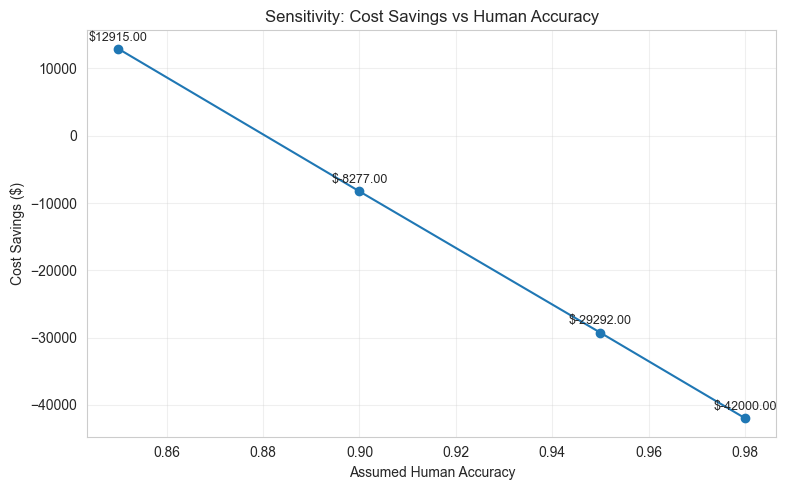

✅ Sensitivity plot saved


In [ ]:
# Plot sensitivity of cost savings vs assumed human accuracy
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(human_review_df['human_accuracy'], human_review_df['cost_savings'], marker='o')
ax.set_xlabel('Assumed Human Accuracy')
ax.set_ylabel('Cost Savings ($)')
ax.set_title('Sensitivity: Cost Savings vs Human Accuracy')
for _, r in human_review_df.iterrows():
    ax.annotate(f"${r['cost_savings']:.2f}", (r['human_accuracy'], r['cost_savings']), textcoords='offset points', xytext=(0,6), ha='center', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/human_accuracy_sensitivity.png', dpi=300)
plt.show()
print("Sensitivity plot saved")

## 16. Export Escalated Case Summary
Persist detailed escalated case information for audit, model risk governance, and future interpretability analysis.

In [ ]:
# Generate and save escalated case summary (top 5 features not available here, using limited context)
escalated_summary = escalation_system.get_escalation_summary(proba_val, uncertainty_val)
print(f"Escalated cases: {len(escalated_summary)}")
escalated_summary.head()
escalated_summary.to_csv('../results/reports/escalated_case_summary.csv', index=False)
print("Escalated case summary saved")

Escalated cases: 100790
✅ Escalated case summary saved


## 17. Risk Segmentation Overview
Classify predictions into actionable buckets combining probability & uncertainty for downstream dashboards.

segment
Medium / Monitor         81434
Low Risk                 16477
High Risk (Confident)     6911
Escalate Zone               36
Name: count, dtype: int64


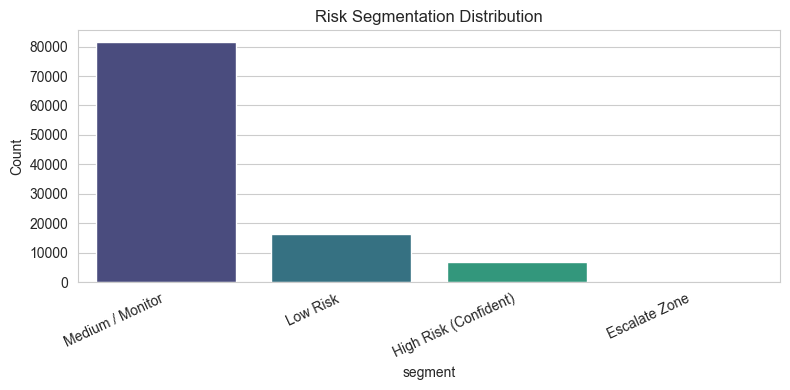

✅ Risk segmentation saved


In [ ]:
# Build segmentation labels
prob_default = proba_val[:,1]
unc = uncertainty_val
segments = []
for p,u in zip(prob_default, unc):
    if u > escalation_system.uncertainty_threshold and 0.4 <= p <= 0.6:
        segments.append('Escalate Zone')
    elif p < 0.3 and u <= escalation_system.uncertainty_threshold:
        segments.append('Low Risk')
    elif p >= 0.7 and u <= escalation_system.uncertainty_threshold:
        segments.append('High Risk (Confident)')
    elif p >= 0.7 and u > escalation_system.uncertainty_threshold:
        segments.append('High Risk (Uncertain)')
    else:
        segments.append('Medium / Monitor')

seg_df = pd.DataFrame({'prob_default': prob_default,'uncertainty': unc,'segment': segments})
seg_counts = seg_df['segment'].value_counts()
print(seg_counts)

plt.figure(figsize=(8,4))
sns.barplot(x=seg_counts.index, y=seg_counts.values, palette='viridis')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Count')
plt.title('Risk Segmentation Distribution')
plt.tight_layout()
plt.savefig('../results/figures/risk_segmentation.png', dpi=300)
plt.show()
seg_df.to_csv('../results/reports/risk_segmentation.csv', index=False)
print("Risk segmentation saved")

## 18. Phase 4 Extended Summary
This extended summary consolidates baseline, optimized, human review simulation, segmentation, and artifacts for reporting upstream.

In [ ]:
# Compile extended summary
# Convert numpy types to native Python types for JSON serialization
extended_summary = {
    'initial_total_cost': float(metrics_initial['total_cost']),
    'optimized_total_cost': float(metrics_optimized['total_cost']),
    'test_total_cost': float(metrics_test['total_cost']),
    'optimized_automation_rate': float(metrics_optimized['automation_rate']),
    'test_automation_rate': float(metrics_test['automation_rate']),
    'human_review_best_cost': float(human_review_df.sort_values('total_cost').iloc[0]['total_cost']),
    'human_review_best_accuracy': float(human_review_df.sort_values('total_cost').iloc[0]['human_accuracy']),
    'n_escalated_validation': int(metrics_optimized['n_escalated']),
    'n_escalated_test': int(metrics_test['n_escalated']),
    'segmentation_counts': {k: int(v) for k, v in seg_counts.to_dict().items()}
}
import json
with open('../results/reports/escalation_extended_summary.json','w') as f:
    json.dump(extended_summary, f, indent=2)
print(json.dumps(extended_summary, indent=2))
print("Extended summary JSON saved")

{
  "initial_total_cost": 61582.0,
  "optimized_total_cost": 50829.0,
  "test_total_cost": 101542.5,
  "optimized_automation_rate": 0.038795323198992926,
  "test_automation_rate": 0.03906253725293851,
  "human_review_best_cost": 50829.0,
  "human_review_best_accuracy": 0.85,
  "n_escalated_validation": 100790,
  "n_escalated_test": 201523,
  "segmentation_counts": {
    "Medium / Monitor": 81434,
    "Low Risk": 16477,
    "High Risk (Confident)": 6911,
    "Escalate Zone": 36
  }
}
✅ Extended summary JSON saved
